# Reflection


在 LLM 智能体构建的背景下，反思指的是促使 LLM 观察其过去步骤（以及来自工具/环境的潜在观察结果）以评估所选行动质量的过程。评估结果随后会用于后续的重新规划、搜索或评估等操作。

<img width="2000" height="1322" alt="image" src="https://github.com/user-attachments/assets/0b269677-85d2-4928-a056-852be8585794" />


本笔记本演示了 LangGraph 中一种非常简单的反射形式。

## Setup

First, let's install our required packages and set our API keys

In [2]:
%pip install -U --quiet  langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
import getpass
import os
os.environ["OPENAI_API_KEY"]=getpass.getpass("ZHIPU_API_KEY")

In [5]:
from google.colab import userdata

os.environ["OPENAI_API_KEY"]=userdata.get("ZHIPU_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>

## Generate

For our example, we will create a "5 paragraph essay" generator. First, create the generator:


In [8]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "你是一名论文助手，任务是撰写优秀的五段式论文。\n 根据用户的要求，尽可能生成最佳论文。\n 如果用户提出批评意见，请回复你之前尝试的修改版本。"
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(
    base_url="https://open.bigmodel.cn/api/paas/v4",
    model="glm-4.5-flash", max_tokens=32768
)
generate = prompt | llm

In [9]:
essay = ""
request = HumanMessage(
    content="请写一篇短文，论述《小王子》在现代儿童生活中为何具有现实意义。"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

# 《小王子》在现代儿童生活中的现实意义

《小王子》作为一部创作于近80年前的经典儿童文学作品，至今仍对现代儿童的成长具有深刻的现实意义。在这个被数字设备包围、节奏日益加快的时代，圣埃克苏佩里通过小王子的视角，为孩子们提供了关于人际关系、想象力与生活本质的永恒智慧。这部作品之所以历久弥新，正是因为它教导儿童在虚拟与现实之间寻找平衡，保持纯真心灵，并思考真正重要的生活价值。

首先，《小王子》在现代儿童生活中具有现实意义，因为它教导孩子们珍视真实的人际关系，而非沉迷于虚拟世界的表面连接。书中那句著名的"重要的东西用眼睛是看不见的，只有用心才能看得清楚"，恰恰呼应了当今社交媒体时代儿童面临的挑战。当孩子们花费大量时间在虚拟平台上追求点赞和关注时，小王子与玫瑰、狐狸和飞行员的友谊提醒我们，真正的连接建立在时间投入、情感交流和相互理解之上。这种对真实关系的珍视，帮助现代儿童在数字洪流中保持人际交往的本质。

其次，《小王子》鼓励儿童保持好奇心和想象力，这在当今应试教育压力日益增大的环境中尤为重要。小王子对成人世界的质疑，如"大人们永远不会自己去了解任何事情，他们总是要孩子来解释"反映了对刻板思维的批判。在标准化测试和固定答案主导的教育背景下，小王子对各个星球的探索象征着不受限制的好奇心和创造性思维。这种鼓励孩子们提问、想象和独立思考的精神，对培养他们的创造力和批判性思维能力至关重要。

最后，《小王子》引导现代儿童思考生活的真正意义和价值观，帮助他们抵制消费主义和物质主义的诱惑。书中对国王、商人等角色的讽刺性描绘，揭示了成人世界中空洞的价值观。当孩子们被广告和同伴压力包围，不断追求最新玩具和时尚产品时，小王子与狐狸的友谊教导我们"正是你为玫瑰花费的时间，使你的玫瑰变得如此重要"。这种对内在价值的强调，帮助孩子们建立超越物质的精神世界，理解责任、承诺和爱的真正含义。

综上所述，《小王子》在现代儿童生活中具有不可替代的现实意义，它教导孩子们珍视真实连接、保持开放思维，并追求有深度的生命体验。在这个充满干扰和诱惑的时代，小王子的智慧如同一盏明灯，指引孩子们在成长过程中保持纯真、善良和对世界的好奇。正如书中所说："所有的大人都曾经是小孩，虽然，只有少数的人记得。"愿更多现代儿童能够通过《小王子》记住这份纯真，并在复杂世界中找到属于自己的方向。

### Reflect

In [10]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "你是一名教师，正在批改一篇作文。请对学生的作文进行点评并提出建议。"
            " 提供详细的建议，包括长度、深度、款式等要求。",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [11]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content


# 作文点评与建议

## 整体评价
这是一篇结构清晰、论述有力的优秀短文。你准确地把握了《小王子》的核心价值，并将其与现代儿童生活的三个关键方面（人际关系、想象力、价值观）进行了有效连接。文章引用恰当，语言流畅，展现了你对文本的深刻理解。

## 具体优点
1. **结构完整**：开头引入主题，中间三个论点层层递进，结尾总结升华，逻辑清晰。
2. **论点明确**：三个分论点分别从人际关系、想象力和价值观角度展开，覆盖了儿童成长的重要方面。
3. **引用恰当**：巧妙运用书中的经典语句作为论据，增强了说服力。
4. **现实联系**：将《小王子》与社交媒体、应试教育、消费主义等现代现象紧密结合，体现了现实关怀。

## 改进建议

### 1. 深度拓展
- **增加理论支撑**：可以在每个论点中加入相关研究或理论。例如，在讨论人际关系时，可引用儿童社交发展研究；在讨论想象力时，可联系创造力培养的教育理念。
- **深化分析**：不仅指出问题，还可以探讨《小王子》如何具体帮助现代儿童应对这些挑战。例如，可以讨论书中"驯养"概念如何帮助儿童建立健康的依恋关系。

### 2. 内容丰富
- **具体案例**：可以增加1-2个具体案例，如现代儿童沉迷社交媒体的现象，或应试教育下儿童创造力受限的实例，使论述更加生动。
- **对比分析**：可简要对比《小王子》与现代其他儿童文学作品的异同，突出其独特价值。
- **读者拓展**：除了对儿童的意义，还可以探讨《小王子》对父母和教育者的启示，扩大文章的受众视角。

### 3. 语言优化
- **增加修辞手法**：可以适当使用排比、设问等修辞手法，增强文章的表现力。例如："当孩子们在虚拟世界中迷失时，当他们在标准化考试中窒息时，当他们在消费主义中困惑时，《小王子》为他们指明了方向。"
- **增强感染力**：可以在结尾部分增加一些更具情感色彩的表述，唤起读者共鸣。

### 4. 结构调整
- **段落过渡**：可以在段落之间增加过渡句，使文章更加连贯。例如，在第一段结尾可以加入："除了人际关系，小王子的冒险旅程还为我们提供了另一面镜子..."
- **行动建议**：可以在结尾部分增加简短的"行动建议"，说明如何将《小王子》的智慧应用到现代儿童生活中，如"父母可以与孩子共读《小王子》，引导他们思考书中的问题，鼓励他们像小

### Repeat

就这么简单！你可以循环执行固定次数，或者使用 LLM（或其他检查）来判断最终产品是否足够好。

In [12]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

# 《小王子》在现代儿童生活中的现实意义

《小王子》作为一部创作于近80年前的经典儿童文学作品，至今仍对现代儿童的成长具有深刻的现实意义。在这个被数字设备包围、节奏日益加快的时代，圣埃克苏佩里通过小王子的视角，为孩子们提供了关于人际关系、想象力与生活本质的永恒智慧。这部作品之所以历久弥新，正是因为它教导儿童在虚拟与现实之间寻找平衡，保持纯真心灵，并思考真正重要的生活价值。

首先，《小王子》在现代儿童生活中具有现实意义，因为它教导孩子们珍视真实的人际关系，而非沉迷于虚拟世界的表面连接。书中那句著名的"重要的东西用眼睛是看不见的，只有用心才能看得清楚"，恰恰呼应了当今社交媒体时代儿童面临的挑战。当孩子们花费大量时间在虚拟平台上追求点赞和关注时，小王子与玫瑰、狐狸和飞行员的友谊提醒我们，真正的连接建立在时间投入、情感交流和相互理解之上。这种对真实关系的珍视，帮助现代儿童在数字洪流中保持人际交往的本质。

其次，《小王子》鼓励儿童保持好奇心和想象力，这在当今应试教育压力日益增大的环境中尤为重要。小王子对成人世界的质疑，如"大人们永远不会自己去了解任何事情，他们总是要孩子来解释"反映了对刻板思维的批判。在标准化测试和固定答案主导的教育背景下，小王子对各个星球的探索象征着不受限制的好奇心和创造性思维。这种鼓励孩子们提问、想象和独立思考的精神，对培养他们的创造力和批判性思维能力至关重要。

最后，《小王子》引导现代儿童思考生活的真正意义和价值观，帮助他们抵制消费主义和物质主义的诱惑。书中对国王、商人等角色的讽刺性描绘，揭示了成人世界中空洞的价值观。当孩子们被广告和同伴压力包围，不断追求最新玩具和时尚产品时，小王子与狐狸的友谊教导我们"正是你为玫瑰花费的时间，使你的玫瑰变得如此重要"。这种对内在价值的强调，帮助孩子们建立超越物质的精神世界，理解责任、承诺和爱的真正含义。

综上所述，《小王子》在现代儿童生活中具有不可替代的现实意义，它教导孩子们珍视真实连接、保持开放思维，并追求有深度的生命体验。在这个充满干扰和诱惑的时代，小王子的智慧如同一盏明灯，指引孩子们在成长过程中保持纯真、善良和对世界的好奇。正如书中所说："所有的大人都曾经是小孩，虽然，只有少数的人记得。"愿更多现代儿童能够通过《小王子》记住这份纯真，并在复杂世界中找到属于自己的方向。

## Define graph

现在我们已经分别展示了每个步骤，我们可以将它们连接成一个图表。

In [13]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


async def generation_node(state: State) -> State:
    return {"messages": [await generate.ainvoke(state["messages"])]}


async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    res = await reflect.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

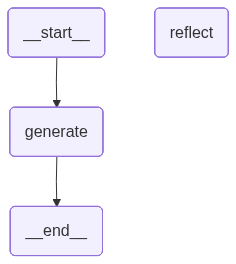

In [17]:
graph

In [18]:
config = {"configurable": {"thread_id": "1"}}

In [19]:
import asyncio

async def run_graph():
    async for event in graph.astream(
        {
            "messages": [
                HumanMessage(
                    content="请就《小王子》及其在现代生活中的意义和寓意撰写一篇论文。"
                )
            ],
        },
        config,
    ):
        print(event)
        print("---")

await run_graph()

{'generate': {'messages': [AIMessage(content='\n# 《小王子》及其在现代生活中的意义和寓意\n\n《小王子》是法国作家安托万·德·圣-埃克苏佩于1943年创作的经典童话作品，虽然表面上是写给儿童的读物，实则蕴含着深刻的人生哲理，成为跨越年龄和文化的文学瑰宝。在这部作品中，作者通过小王子在各个星球的游历，以及他与飞行员的相遇，探讨了爱、责任、友谊和生命意义等永恒主题。在当今快节奏、高压力的现代社会中，《小王子》所传达的简单而深刻的智慧，为我们提供了反思生活本质、重拾纯真视角的宝贵启示，其意义和寓意不仅没有随时间流逝而减弱，反而愈发凸显出对现代生活的指导价值。\n\n《小王子》的核心象征与寓意构成了这部作品的艺术魅力和哲学深度。小王子来自一颗微小的星球，象征着纯真和未被世俗污染的心灵；他拜访的六个星球上的成人——国王、爱虚荣的人、酒鬼、商人、点灯人和地理学家，则代表了成人世界中各种异化的状态：权力欲、虚荣心、逃避现实、功利主义、盲目忙碌和空谈理论。这些角色共同构成了现代社会的缩影，警示人们在成长过程中可能迷失的方向。书中"用心去看才清楚，本质的东西眼睛是看不见的"这一核心主题，以及"驯养"概念所强调的建立独特联系的重要性，都指向了人际关系中真诚与情感的珍贵，这些象征和寓意超越了时代限制，成为永恒的真理。\n\n在现代生活中，《小王子》的智慧对对抗异化现象具有特殊意义。现代社会普遍存在的功利主义和物质主义倾向，使人们逐渐迷失在数字化的表象和物质追求中，而忘记了生活的本质。正如书中那些只关心数字、权力和地位的成人角色，现代人也常常陷入"重要事务"的迷思，却忽略了真正带来幸福的人际关系和内心体验。在社交媒体盛行的时代，人们看似连接更加紧密，实则情感疏离加剧，正如小王子感叹："你对你驯养的东西永远负有责任。"这种对责任和真诚关系的强调，正是对抗现代生活异化的良药。\n\n《小王子》为现代生活中的困境提供了富有洞察力的解决方案。面对信息过载和选择困难，小王子提醒我们"真正重要的东西用眼睛是看不见的"，引导我们超越表象，关注本质；在人际关系日益功利化的今天，"驯养"概念强调了建立真诚联系的重要性，提醒我们在快节奏的生活中不要忘记用心去关爱他人；面对工作和生活的平衡问题，小王子与狐狸的对话揭示了"仪式感"的价值，教导我们在平凡生活中创造

In [20]:
state = graph.get_state(config)

In [ ]:
state

In [22]:
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

请就《小王子》及其在现代生活中的意义和寓意撰写一篇论文。

================================== Ai Message ==================================


# 《小王子》及其在现代生活中的意义和寓意

《小王子》是法国作家安托万·德·圣-埃克苏佩于1943年创作的经典童话作品，虽然表面上是写给儿童的读物，实则蕴含着深刻的人生哲理，成为跨越年龄和文化的文学瑰宝。在这部作品中，作者通过小王子在各个星球的游历，以及他与飞行员的相遇，探讨了爱、责任、友谊和生命意义等永恒主题。在当今快节奏、高压力的现代社会中，《小王子》所传达的简单而深刻的智慧，为我们提供了反思生活本质、重拾纯真视角的宝贵启示，其意义和寓意不仅没有随时间流逝而减弱，反而愈发凸显出对现代生活的指导价值。

《小王子》的核心象征与寓意构成了这部作品的艺术魅力和哲学深度。小王子来自一颗微小的星球，象征着纯真和未被世俗污染的心灵；他拜访的六个星球上的成人——国王、爱虚荣的人、酒鬼、商人、点灯人和地理学家，则代表了成人世界中各种异化的状态：权力欲、虚荣心、逃避现实、功利主义、盲目忙碌和空谈理论。这些角色共同构成了现代社会的缩影，警示人们在成长过程中可能迷失的方向。书中"用心去看才清楚，本质的东西眼睛是看不见的"这一核心主题，以及"驯养"概念所强调的建立独特联系的重要性，都指向了人际关系中真诚与情感的珍贵，这些象征和寓意超越了时代限制，成为永恒的真理。

在现代生活中，《小王子》的智慧对对抗异化现象具有特殊意义。现代社会普遍存在的功利主义和物质主义倾向，使人们逐渐迷失在数字化的表象和物质追求中，而忘记了生活的本质。正如书中那些只关心数字、权力和地位的成人角色，现代人也常常陷入"重要事务"的迷思，却忽略了真正带来幸福的人际关系和内心体验。在社交媒体盛行的时代，人们看似连接更加紧密，实则情感疏离加剧，正如小王子感叹："你对你驯养的东西永远负有责任。"这种对责任和真诚关系的强调，正是对抗现代生活异化的良药。

《小王子》为现代生活中的困境提供了富有洞察力的解决方案。面对信息过载和选择困难，小王子提

## Conclusion

既然你已经将反思机制应用于 LLM 智能体，我想指出一点：自我反思本质上是一个循环过程：如果反思步骤包含额外的上下文或反馈（例如来自工具的观察、检查等），效果会更好。如果像上述场景一样，反思步骤只是提示 LLM 反思其输出，虽然仍然可以提升输出质量（因为 LLM 因此有多次机会获得良好的输出），但效果的保证性会降低。
